<h1 align="center"> Predicting News Popularity </h1>
<h4 align="center"> Competition 01 </h4>
<h4 align="center"> Team: 讓我活下去 </h4>
<h4 align="center"> Members: 李泓緯、林孟萱、陳隆琦、陳家惠 </h4>

<div class="alert alert-block alert-info">
<b><font size="4">Info:</font></b> <font size="3">In this competition, you are provided with a supervised dataset X consisting of the raw content of news articles and the binary popularity (where 1 means "popular" and -1 not, calculated based on the number of shares in online social networking services) of these articles as labels. Your goal is to learn a function f from X that is able to predict the popularity of an unseen news article</font>
</div>

# **Import package and load datasets**

In [409]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib.font_manager import FontProperties
import seaborn as sns
from collections import Counter

#################################### Data Preprocessing #####################################
###### Use for html document
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import re

######## Remove warning
import warnings
warnings.simplefilter("ignore")

######## For LDA model
import gensim 
import gensim.corpora as corpora
import pyLDAvis
import pickle
from pyLDAvis import gensim_models
from gensim.models import CoherenceModel
pyLDAvis.enable_notebook()

from collections import Counter

from pprint import pprint


#################################### Classification Model #####################################
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import lightgbm as lgb

# new added
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


plt.rcParams["figure.figsize"] = [20, 7]  # width, height
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['font.family'] = ['Arial Unicode MS'] #正常顯示中文 
plt.rcParams['font.sans-serif'] = ['KaiTi']#作圖的中文
plt.rcParams['font.serif'] = ['KaiTi']#作圖的中文
plt.rcParams['axes.unicode_minus'] = False # 解決保存圖像是負號'-'顯示為方塊的問題

In [324]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [325]:
data.head()

,Id,Popularity,Page content
0,0,-1,"<html><head><div class=""article-info""> <span c..."
1,1,1,"<html><head><div class=""article-info""><span cl..."
2,2,1,"<html><head><div class=""article-info""><span cl..."
3,3,-1,"<html><head><div class=""article-info""><span cl..."
4,4,-1,"<html><head><div class=""article-info""><span cl..."


可以從上面 Output 中看到，整體資料只有 id, Popularity 和 Page content，其中 Popularity 代表新聞的熱門與否，1 代表熱門，-1 代表不熱門，為最後要預測的 response； Page content 為從網路上爬取下來的文檔，需要將其當作 variable 來做預測，但因為文檔為網路資料，所以會有 HTML 的語法出現，後面需要對其做文字預處理（Text preprocessing）才能做其他的特徵工程（Feature enginnering）

***

# **Text Preprocessing**

將訓練資料（Training data）切割成 X 為 predictor、y 為 response，並將 Training data 和測試資料（Testing data）合併一起做 Text preprocessing 和 Feature engineering

In [326]:
X = data.drop('Popularity', axis = 1)

X = pd.concat([X, test], axis=0).reset_index() ### 因為資料合併，需使用 reset_index()
y = data['Popularity']
# required further adjust, since like there exists better way to transfrom 

## **Function to feature engineering**

定義函數來對 HTML 文檔進行資料萃取，例如作者、新聞發布時間、新聞主題、新聞標題及新聞內文，接者透過萃取出資料來進行 Feature engineering

### Extract the author

In [327]:
def Author_Extract(text):
    soup = BeautifulSoup(text,"html.parser")
    return(soup.find(attrs = {"class": "author_name"}).get_text().replace('By','').replace('by','').strip())

### Extract the time

In [328]:
def Time_Extract(text):
    soup = BeautifulSoup(text,"html.parser")
    return(soup.find('time').get_text())

### Extract the topic

In [329]:
def Topic_Extract(text):
    soup = BeautifulSoup(text,"html.parser")
    return(soup.find(attrs = {"class": "article-topics"}).get_text().replace('Topics','').replace(':','').strip())

### Extract the title

In [330]:
def Title_Extract(text):
    soup = BeautifulSoup(text,"html.parser")
    return(soup.find('h1').get_text())

### Extract the article

In [331]:
def Article_Extract(text):
    # remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    
    paragraphs = soup.find_all('p')
    article = []
    for p in paragraphs:
        
        # let the world lower
        text = p.get_text().lower()
        
        # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
        r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
        emoticons = re.findall(r, text)
        text = re.sub(r, '', text)
        
        # replace('-','') removes nose of emoticons
        text = re.sub('[\W]+', ' ', text) + ' ' + ' '.join(emoticons).replace('-','')
        
        # Output the text
        article.append(text.strip())
        article_str = ''.join(article)
        
    return(article_str)

### Show the example

可以透過以下例子呈現：

In [332]:
print('[Author]: ', Author_Extract(data['Page content'][1]))
print('[Time]: ', Time_Extract(data['Page content'][1]))
print('[Topic]: ', Topic_Extract(data['Page content'][1]))
print('[Title]: ', Title_Extract(data['Page content'][1]))
print('[Article]: ', Article_Extract(data['Page content'][1]))

[Author]:  Christina Warren
[Time]:  2013-03-28 17:40:55 UTC
[Topic]:  Apps and Software, Google, open source, opn pledge, patent lawsuit theater, software patents, Tech, U.S.
[Title]:  Google's New Open Source Patent Pledge: We Won't Sue Unless Attacked First
[Article]:  google took a stand of sorts against patent lawsuit theater thursday with its new open patent non assertion opn pledgeas explained by google s duane valz under the opn pledge google promises not to sue any user distributor or developer of open source software on specified patents unless first attackednow google isn t making all of its patents available for others instead its starting small with 10 patents focused on mapreduce a programming model for handling large data sets there are already open sourced versions of mapreduce available including hadoop that are widely used across the internet google says that over time it plans to extend the opn pledge to more google patentssee also 10 interesting google glass winners

In [333]:
### 呈現該文檔 HTML 語法形式
#print(soup_train.prettify())

***

## **Feature Engineering**

前面將新聞文檔從 HTML 文檔中萃取出來，接者透過模型（例如 Latent Dirichlet allocation 找出文檔潛在主題分佈）或是一些常見手法如判斷文章發佈日期是否為假日、文章長短等，對資料生成特徵來訓練模型。

### **Topic model**

Latent Dirichlet allocation（LDA） 是一種主題模型，它可以將每篇文檔中的主題按照機率分布的形式呈現。同時它是一種無監督學習算法，在訓練時僅需要文檔集以及指定主題的數量 K

<p align="center">
    <img src="img/LDA.jpeg" alt="LDA" width="600"/>
</p>

上圖為 LDA 的模型結構圖，其中灰色圓圈為觀察到的變量（文字），白色圓圈為隱變量或參數，
其中 $\theta_i$ 為第 i 篇文章中各個主題出現的機率，會服從 $Dir(\alpha)$， $\beta_k$ 為第 k 個主題中各個用詞出現的機率，會服從 $Dir(\eta)$，$\alpha$ 是主題分佈 $\theta_i$ 的分配參數，N 代表文檔中的單詞總數，M 代表文檔的總數

在做 LDA 前也需要對其文檔做切割處理，可切割成 unigram、bigram 或 ngram 等，本次分析因為詞語較少出現兩個字詞以上的詞語，故主要使用 unigram 對其文檔進行切割，流程如下：

#### **Text split**

對其新聞文檔做內文萃取並做 unigram 切割

In [335]:
X["Article"] = X.apply(lambda row: Article_Extract(row['Page content']), axis=1)
X["Article"] = X["Article"].astype(str)

原先有對內文中的數字做清洗，不過由於在做最後的分類時，發現效果並沒有比為做數字清洗來得好，故此選擇單純做 word_tokenize 的文字切割

In [336]:
def remove_number_and_word_tokenize(text):
    text = re.sub(r'\d+', '', text)
    text_tokenize = word_tokenize(text)
    return(text_tokenize)

In [337]:
X["Article_sp"] = X.apply(lambda row: word_tokenize(row['Article']), axis=1)

In [338]:
X

,index,Id,Page content,Article,Article_sp
0,0,0,"<html><head><div class=""article-info""> <span c...",there may be killer asteroids headed for earth...,"[there, may, be, killer, asteroids, headed, fo..."
1,1,1,"<html><head><div class=""article-info""><span cl...",google took a stand of sorts against patent la...,"[google, took, a, stand, of, sorts, against, p..."
2,2,2,"<html><head><div class=""article-info""><span cl...",you ve spend countless hours training to be an...,"[you, ve, spend, countless, hours, training, t..."
3,3,3,"<html><head><div class=""article-info""><span cl...",tired of the same old sports fails and news fa...,"[tired, of, the, same, old, sports, fails, and..."
4,4,4,"<html><head><div class=""article-info""><span cl...",at 6 foot 5 and 298 pounds all pro nfl star j ...,"[at, 6, foot, 5, and, 298, pounds, all, pro, n..."
...,...,...,...,...,...
39485,11842,39485,"<html><head><div class=""article-info""><span cl...",some of the creators of twitter have landed on...,"[some, of, the, creators, of, twitter, have, l..."
39486,11843,39486,"<html><head><div class=""article-info""><span cl...",full disclosure jetpack joyride is still one o...,"[full, disclosure, jetpack, joyride, is, still..."
39487,11844,39487,"<html><head><div class=""article-info""><span cl...",los angeles nominees for the 56th grammy award...,"[los, angeles, nominees, for, the, 56th, gramm..."
39488,11845,39488,"<html><head><div class=""article-info""><span cl...",the latest version of google s nexus 7 has bec...,"[the, latest, version, of, google, s, nexus, 7..."


可從以上 output 看出新聞內文被翠看出來，且已對該文檔做切割，接者需要對切割後的文檔進行 stopwords 的清洗或是其他處理（如 文法處理）手法

#### Stop-Word Removal and Stemming

* 利用 nltk 中的 stopwords 資料庫來對新聞內文做清洗，將較無意義字詞做刪減，如 'you'、'I'、'am'，這些字詞再讓我們做 LDA 上可能較無意義

* 且透過 PorterStemmer 和 WordNetLemmatizer 對字詞的詞性文法做修正，舉例來說：'asteroids' 變成 'asteroid' 或 'headed' 變成 'head'

In [339]:
sr = stopwords.words('english')
sr.extend([',',':','.','(',')',"'",'nt','>','<','?','-','_','*','%',';','~','`','``','--','[',']','[]',"'s",'also','imag','courtesi'])

In [340]:
def tokenizer_stem_lemma_nostop(text):
    clean_tokens = []
    
    # Remove stopwords
    for token in text:
        if token not in sr:
            clean_tokens.append(token)

    # PorterStemmer
    porter = PorterStemmer()
    clean_tokens_porter = [porter.stem(w) for w in clean_tokens]
    
    # Lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    clean_tokens_lemmatizer = [wordnet_lemmatizer.lemmatize(w, pos="v") for w in clean_tokens_porter]

    return(clean_tokens_lemmatizer)

In [341]:
X["Article_clean"] = X.apply(lambda row: tokenizer_stem_lemma_nostop(row['Article_sp']), axis=1)

In [342]:
X.head()

,index,Id,Page content,Article,Article_sp,Article_clean
0,0,0,"<html><head><div class=""article-info""> <span c...",there may be killer asteroids headed for earth...,"[there, may, be, killer, asteroids, headed, fo...","[may, killer, asteroid, head, earth, nasa, dec..."
1,1,1,"<html><head><div class=""article-info""><span cl...",google took a stand of sorts against patent la...,"[google, took, a, stand, of, sorts, against, p...","[googl, take, stand, sort, patent, lawsuit, th..."
2,2,2,"<html><head><div class=""article-info""><span cl...",you ve spend countless hours training to be an...,"[you, ve, spend, countless, hours, training, t...","[spend, countless, hour, train, american, foot..."
3,3,3,"<html><head><div class=""article-info""><span cl...",tired of the same old sports fails and news fa...,"[tired, of, the, same, old, sports, fails, and...","[tire, old, sport, fail, news, fail, let, came..."
4,4,4,"<html><head><div class=""article-info""><span cl...",at 6 foot 5 and 298 pounds all pro nfl star j ...,"[at, 6, foot, 5, and, 298, pounds, all, pro, n...","[6, foot, 5, 298, pound, pro, nfl, star, j, j,..."


#### **Remove more token**

在做 LDA 選取主題時，會發現到各個主題內較常出現的字詞都差不多，所以此處考慮對所有文檔中較常出現的字詞做刪減，此處設定頻率次數為 10000，代表說若某字詞出現在所有文檔中的次數大於 10000 次，就做刪減

In [343]:
text_all = X['Article_clean'].values.tolist()

In [344]:
### 可以看出較常出現的字詞
token_all = []
for index in range(len(text_all)):
    token_all.extend(text_all[index])
count = Counter(token_all).most_common()

#### **Build more_token dictionary**

建立頻率較常出現的字詞的字典，可對文檔做刪減

In [345]:
fewer_token = [] ## 同時建立低頻率的字典
more_token = []

for index in range(len(count)):
    num = count[index][1]
    if num < 10: # 字詞頻率設為 10
        fewer_token.append(count[index][0])
    if num > 10000: # 字詞頻率設為 10000
        more_token.append(count[index][0])

對文檔做高頻率單字刪減：

In [346]:
def remove_more_token(text):
    
    clean_more_token = filter(lambda n: n not in more_token, text)

    return(list(clean_more_token))

In [347]:
X["Article_clean_more"] = X.apply(lambda row: remove_more_token(row['Article_clean']), axis=1)

In [348]:
X

,index,Id,Page content,Article,Article_sp,Article_clean,Article_clean_more
0,0,0,"<html><head><div class=""article-info""> <span c...",there may be killer asteroids headed for earth...,"[there, may, be, killer, asteroids, headed, fo...","[may, killer, asteroid, head, earth, nasa, dec...","[killer, asteroid, head, earth, nasa, decid, a..."
1,1,1,"<html><head><div class=""article-info""><span cl...",google took a stand of sorts against patent la...,"[google, took, a, stand, of, sorts, against, p...","[googl, take, stand, sort, patent, lawsuit, th...","[stand, sort, patent, lawsuit, theater, thursd..."
2,2,2,"<html><head><div class=""article-info""><span cl...",you ve spend countless hours training to be an...,"[you, ve, spend, countless, hours, training, t...","[spend, countless, hour, train, american, foot...","[spend, countless, hour, train, american, foot..."
3,3,3,"<html><head><div class=""article-info""><span cl...",tired of the same old sports fails and news fa...,"[tired, of, the, same, old, sports, fails, and...","[tire, old, sport, fail, news, fail, let, came...","[tire, old, sport, fail, fail, cameraperson, f..."
4,4,4,"<html><head><div class=""article-info""><span cl...",at 6 foot 5 and 298 pounds all pro nfl star j ...,"[at, 6, foot, 5, and, 298, pounds, all, pro, n...","[6, foot, 5, 298, pound, pro, nfl, star, j, j,...","[6, foot, 298, pound, pro, nfl, j, j, watt, te..."
...,...,...,...,...,...,...,...
39485,11842,39485,"<html><head><div class=""article-info""><span cl...",some of the creators of twitter have landed on...,"[some, of, the, creators, of, twitter, have, l...","[creator, twitter, land, pretti, new, perch, s...","[creator, land, pretti, perch, san, francisco,..."
39486,11843,39486,"<html><head><div class=""article-info""><span cl...",full disclosure jetpack joyride is still one o...,"[full, disclosure, jetpack, joyride, is, still...","[full, disclosur, jetpack, joyrid, still, one,...","[full, disclosur, jetpack, joyrid, favorit, io..."
39487,11844,39487,"<html><head><div class=""article-info""><span cl...",los angeles nominees for the 56th grammy award...,"[los, angeles, nominees, for, the, 56th, gramm...","[lo, angel, nomine, 56th, grammi, award, sunda...","[lo, angel, nomine, 56th, grammi, award, sunda..."
39488,11845,39488,"<html><head><div class=""article-info""><span cl...",the latest version of google s nexus 7 has bec...,"[the, latest, version, of, google, s, nexus, 7...","[latest, version, googl, nexu, 7, becom, avail...","[latest, version, nexu, 7, becom, avail, purch..."


可以從上面 output 看到，Article_clean 中第一行的 'may'，因為屬於高頻文字，故做刪減，因此在 Article_clean_more 中第一行看到 'may' 被做刪除

#### **Build LDA model**

建立 LDA 模型時，需要對主題數 K 做選擇，我們主要使用 Topic Coherence 來做模型的權衡，Topic Coherence 代表了單個主題內單詞之間的相對距離或一致性，通常 Topic Coherence 越高越好

根據以下函數，來呈現各個主題數下的 Topic Coherence 值 

In [349]:
def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3, coherence='c_v'):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model_lda = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model_lda)
        coherencemodel = CoherenceModel(model=model_lda, texts=texts, dictionary=id2word, coherence= coherence)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [350]:
text_all = X['Article_clean_more'].values.tolist()

建立 LDA 模型所需語料庫、文檔

In [351]:
id2word_all = corpora.Dictionary(text_all)

corpus_all = [id2word_all.doc2bow(token) for token in text_all]

texts_all = text_all

進行 LDA 主題數選取

In [ ]:
model_list, coherence_values = compute_coherence_values(texts = texts_all, 
                               corpus = corpus_all, 
                               id2word = id2word_all, 
                               start=2, limit = 30, step=2, coherence = 'c_v')

print(coherence_values)

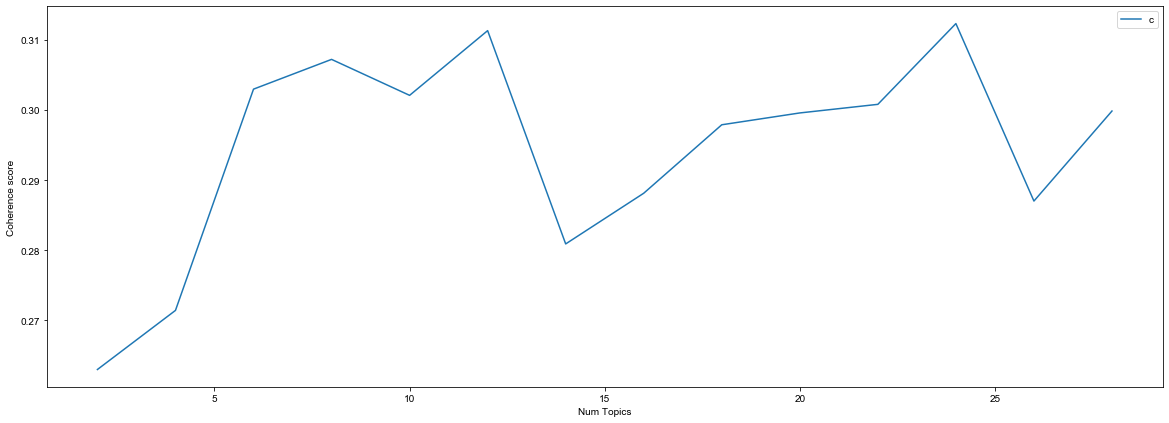

In [434]:
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [435]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.263
Num Topics = 4  has Coherence Value of 0.2714
Num Topics = 6  has Coherence Value of 0.303
Num Topics = 8  has Coherence Value of 0.3072
Num Topics = 10  has Coherence Value of 0.3021
Num Topics = 12  has Coherence Value of 0.3113
Num Topics = 14  has Coherence Value of 0.2809
Num Topics = 16  has Coherence Value of 0.2881
Num Topics = 18  has Coherence Value of 0.2979
Num Topics = 20  has Coherence Value of 0.2996
Num Topics = 22  has Coherence Value of 0.3008
Num Topics = 24  has Coherence Value of 0.3123
Num Topics = 26  has Coherence Value of 0.287
Num Topics = 28  has Coherence Value of 0.2998


可以看到最大的值為在主題數 12，Topic Coherence 為 0.3113，故選擇主題數 K 為 12 建立 LDA 模型

In [352]:
num_topics = 12
lda_model = gensim.models.LdaMulticore(corpus=corpus_all,
                                          id2word=id2word_all,
                                          num_topics=num_topics,
                                          minimum_probability=0.0)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus_all]

[(0,
  '0.002*"cup" + 0.002*"4" + 0.002*"microsoft" + 0.001*"tv" + 0.001*"plan" + '
  '0.001*"search" + 0.001*"avail" + 0.001*"offic" + 0.001*"screen" + '
  '0.001*"car"'),
 (1,
  '0.002*"offic" + 0.002*"polic" + 0.002*"car" + 0.002*"camera" + '
  '0.002*"price" + 0.001*"shoot" + 0.001*"pic" + 0.001*"screen" + '
  '0.001*"govern" + 0.001*"amazon"'),
 (2,
  '0.002*"android" + 0.002*"account" + 0.002*"content" + 0.002*"instagram" + '
  '0.002*"tweet" + 0.002*"4" + 0.002*"number" + 0.002*"polic" + 0.001*"recent" '
  '+ 0.001*"pic"'),
 (3,
  '0.002*"tweet" + 0.001*"research" + 0.001*"nation" + 0.001*"project" + '
  '0.001*"storm" + 0.001*"hour" + 0.001*"interview" + 0.001*"4" + '
  '0.001*"event" + 0.001*"origin"'),
 (4,
  '0.003*"ipad" + 0.003*"emil" + 0.002*"lendofphoto" + 0.002*"screen" + '
  '0.002*"song" + 0.002*"email" + 0.002*"send" + 0.001*"provid" + '
  '0.001*"event" + 0.001*"music"'),
 (5,
  '0.003*"friend" + 0.002*"flickr" + 0.002*"movi" + 0.002*"film" + '
  '0.002*"stori" + 0.

In [353]:
# LDA 模型可視化
#pyLDAvis.gensim_models.prepare(lda_model, corpus_all, id2word_all)

In [354]:
theta1 = []
theta2 = []
theta3 = []
theta4 = []
theta5 = []
theta6 = []
theta7 = []
theta8 = []
theta9 = []
theta10 = []
theta11 = []
theta12 = []

for index in range(len(corpus_all)):
    theta1.append(lda_model[corpus_all[index]][0][1])
    theta2.append(lda_model[corpus_all[index]][1][1])
    theta3.append(lda_model[corpus_all[index]][2][1])
    theta4.append(lda_model[corpus_all[index]][3][1])
    theta5.append(lda_model[corpus_all[index]][4][1])
    theta6.append(lda_model[corpus_all[index]][5][1])
    theta7.append(lda_model[corpus_all[index]][6][1])
    theta8.append(lda_model[corpus_all[index]][7][1])
    theta9.append(lda_model[corpus_all[index]][8][1])
    theta10.append(lda_model[corpus_all[index]][9][1])
    theta11.append(lda_model[corpus_all[index]][10][1])
    theta12.append(lda_model[corpus_all[index]][11][1])

theta1 = np.asarray(theta1)
theta2 = np.asarray(theta2)
theta3 = np.asarray(theta3)
theta4 = np.asarray(theta4)
theta5 = np.asarray(theta5)
theta6 = np.asarray(theta6)
theta7 = np.asarray(theta7)
theta8 = np.asarray(theta8)
theta9 = np.asarray(theta9)
theta10 = np.asarray(theta10)
theta11 = np.asarray(theta11)
theta12 = np.asarray(theta12)

建立各個文檔的主題的矩陣，可以看到每一個文檔的主題分佈

In [355]:
documents_topics_matrix = pd.DataFrame({"Topic 1" : theta1,
                                        "Topic 2" : theta2,
                                        "Topic 3" : theta3,
                                        "Topic 4" : theta4,
                                        "Topic 5" : theta5,
                                        "Topic 6" : theta6,
                                        "Topic 7" : theta7,
                                        "Topic 8" : theta8,
                                        "Topic 9" : theta9,
                                        "Topic 10" : theta10,
                                        "Topic 11" : theta11,
                                        "Topic 12" : theta12
                                       }) 

***

### **Adding others feature** 

發現用 LDA 模型輸出的 Topic distribution 變數進分類器模型中，Public Leaderboard 大致 AUC 為 0.54 左右，若需找到更高的分數，勢必加入其他變數進行分類，以下為新增的變數：
* 判斷該新聞發布時間（Find_weekend）：output 0 代表星期一、1 代表星期二、...、6 代表星期天、7 代表此新聞無顯示發布時間。根據一般使用者，我們猜測五六日對於新聞的觸及率，會比平日來得高，也從最後的分類器模型中去以看出，加入此變數對於我們最後 AUC 分數有不錯的提升

In [356]:
def Find_weekend(text):
    date_str = Time_Extract(text).split(' ')[0]
    if date_str == '':
        return(7)
    date = pd.Timestamp(date_str)
    week = date.dayofweek
    return(int(week))

In [393]:
X["Week"] = X.apply(lambda row: Find_weekend(row['Page content']), axis=1)

* 抓取新聞所使用照片數量及連結數量：Image 為抓取照片數量、Links 為抓取連結數量。同樣的，我們猜測若一篇文章擁有較多資訊（例如：圖片、網頁連結...等），會比一般只有文字的文章來得受歡迎

In [358]:
### Links_Image
def Images_Extract(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.findAll('img')

def Links_Extract(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.findAll('a')

def Image(text):
    Image_str = Images_Extract(text)
    Links_str = Links_Extract(text)
    return len(Image_str)

def Links(text):
    Image_str = Images_Extract(text)
    Links_str = Links_Extract(text)
    return len(Links_str)

In [359]:
X["image"] = X.apply(lambda row: Image(row['Page content']), axis=1)
X["link"] = X.apply(lambda row: Links(row['Page content']), axis=1)

* 抓取新聞內文和標題的長短：article_length 為抓取內文文章長短、title_length 為抓取標題長短。同樣的，我們猜測若一篇文章的標題較短，可能會比較吸引使用者點進去閱讀新聞

In [360]:
def title_length(text):
    title = Title_Extract(text)
    title = word_tokenize(title)
    return(len(title))

In [361]:
X["title_length"] = X.apply(lambda row: title_length(row['Page content']), axis=1)

In [362]:
X["article_length"] = X.apply(lambda row: len(row['Article_sp']), axis=1)

In [363]:
X

,index,Id,Page content,Article,Article_sp,Article_clean,Article_clean_more,link_number,image,link,title_length,article_length
0,0,0,"<html><head><div class=""article-info""> <span c...",there may be killer asteroids headed for earth...,"[there, may, be, killer, asteroids, headed, fo...","[may, killer, asteroid, head, earth, nasa, dec...","[killer, asteroid, head, earth, nasa, decid, a...",2,1,22,10,557
1,1,1,"<html><head><div class=""article-info""><span cl...",google took a stand of sorts against patent la...,"[google, took, a, stand, of, sorts, against, p...","[googl, take, stand, sort, patent, lawsuit, th...","[stand, sort, patent, lawsuit, theater, thursd...",3,2,18,15,310
2,2,2,"<html><head><div class=""article-info""><span cl...",you ve spend countless hours training to be an...,"[you, ve, spend, countless, hours, training, t...","[spend, countless, hour, train, american, foot...","[spend, countless, hour, train, american, foot...",2,2,11,14,1012
3,3,3,"<html><head><div class=""article-info""><span cl...",tired of the same old sports fails and news fa...,"[tired, of, the, same, old, sports, fails, and...","[tire, old, sport, fail, news, fail, let, came...","[tire, old, sport, fail, fail, cameraperson, f...",4,1,13,5,163
4,4,4,"<html><head><div class=""article-info""><span cl...",at 6 foot 5 and 298 pounds all pro nfl star j ...,"[at, 6, foot, 5, and, 298, pounds, all, pro, n...","[6, foot, 5, 298, pound, pro, nfl, star, j, j,...","[6, foot, 298, pound, pro, nfl, j, j, watt, te...",3,52,16,10,191
...,...,...,...,...,...,...,...,...,...,...,...,...
39485,11842,39485,"<html><head><div class=""article-info""><span cl...",some of the creators of twitter have landed on...,"[some, of, the, creators, of, twitter, have, l...","[creator, twitter, land, pretti, new, perch, s...","[creator, land, pretti, perch, san, francisco,...",5,3,12,9,123
39486,11843,39486,"<html><head><div class=""article-info""><span cl...",full disclosure jetpack joyride is still one o...,"[full, disclosure, jetpack, joyride, is, still...","[full, disclosur, jetpack, joyrid, still, one,...","[full, disclosur, jetpack, joyrid, favorit, io...",3,4,10,11,572
39487,11844,39487,"<html><head><div class=""article-info""><span cl...",los angeles nominees for the 56th grammy award...,"[los, angeles, nominees, for, the, 56th, gramm...","[lo, angel, nomine, 56th, grammi, award, sunda...","[lo, angel, nomine, 56th, grammi, award, sunda...",2,10,33,11,716
39488,11845,39488,"<html><head><div class=""article-info""><span cl...",the latest version of google s nexus 7 has bec...,"[the, latest, version, of, google, s, nexus, 7...","[latest, version, googl, nexu, 7, becom, avail...","[latest, version, nexu, 7, becom, avail, purch...",2,2,11,11,134


* 抓取發文日期距離年底的日數，好奇在一年中哪一天發布是否對於結果會有影響，最後也發現此變數加入模型後，對 AUC 分數也有提升

In [364]:
from datetime import datetime

def day_delta(text):
    time_str = Time_Extract(text)
    if time_str == '':
        return 0
    time_arr = time_str.split(' ')

    year = time_arr[0].split('-')[0]
    target_str = year+'-12-31 23:59:59'
    target = datetime.strptime(target_str, '%Y-%m-%d %H:%M:%S')
    day = datetime.strptime(time_arr[0]+' '+time_arr[1], '%Y-%m-%d %H:%M:%S')
    delta = (target - day).days
    return delta

In [365]:
X["day_delta"] = X.apply(lambda row: day_delta(row['Page content']), axis=1)

### **TF-idf**

tf-idf（term frequency–inverse document frequency）是一種統計方法，用以評估一字詞對於一個檔案集或一個語料庫中的其中一份檔案的重要程度。字詞的重要性隨著它在檔案中出現的次數成正比增加，但同時會隨著它在語料庫中出現的頻率成反比下降

* 此處對新聞標題和內文做 tf-idf，其中 tf-idf 裡的字詞抓取，先對出現在 stopwords 字典裡字詞做刪減，再以頻率最高的前 20 個詞計算其值，並當作變數來做分類

可以從分類器的 AUC 分數中發現加入 tf-idf 這個變數，對於分數有些微的提高，可以推斷字詞的重要程度對於新聞熱門程度有影響

In [366]:
from sklearn.feature_extraction.text import TfidfVectorizer  

In [367]:
def join_string(text):
    return(' '.join(text))

如同內文的處理，此處同樣對標題進行文字前處理，如文字清洗、字詞切割

In [378]:
X["Title"] = X.apply(lambda row: Title_Extract(row['Page content']), axis=1)

In [382]:
X['Title_sp'] = X.apply(lambda row: word_tokenize(row['Title']), axis=1)

In [383]:
X["Title_clean"] = X.apply(lambda row: tokenizer_stem_lemma_nostop(row['Title_sp']), axis=1)

In [384]:
X["Join_string_title"] = X.apply(lambda row: join_string(row['Title_clean']), axis=1)

In [386]:
srsr = stopwords.words('english')
srsr.extend(['get','make','thi'])

In [387]:
v = TfidfVectorizer(max_features=20,stop_words = srsr)
x = v.fit_transform(X["Join_string_title"])

df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
#df.drop('text', axis=1, inplace=True)
#res = pd.concat([df, df1], axis=1)

In [388]:
### 標題的 tf-idf
df1 

,10,ad,app,appl,day,facebook,first,game,googl,iphon,know,new,photo,show,time,twitter,video,watch,world,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.641058,0.0,0.583647,0.0,0.0,0.498399,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39485,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.636166,0.0,0.0,0.0,0.771552,0.0,0.0,0.0,0.0
39486,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
39487,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
39488,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [389]:
X["Join_string_article"] = X.apply(lambda row: join_string(row['Article_clean_more']), axis=1)

In [390]:
v = TfidfVectorizer(max_features=20,stop_words = srsr)
x = v.fit_transform(X["Join_string_article"])

df2 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
#df.drop('text', axis=1, inplace=True)
#res = pd.concat([df, df1], axis=1)

In [391]:
### 內文的 tf-idf
df2

,allow,ask,avail,bring,digit,event,friend,inform,move,music,name,old,origin,plan,provid,put,recent,screen,stori,turn
0,0.000000,0.281259,0.000000,0.000000,0.0,0.312169,0.000000,0.598063,0.000000,0.000000,0.00000,0.000000,0.266692,0.564104,0.276454,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.825865,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.405498,0.000000,0.391814,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.375102,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.184278,0.655776,0.00000,0.000000,0.177837,0.000000,0.184347,0.545197,0.000000,0.000000,0.000000,0.180134
3,0.000000,0.000000,0.000000,0.000000,0.0,0.745687,0.000000,0.000000,0.000000,0.000000,0.00000,0.666297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.603546,0.000000,0.555626,0.000000,0.57185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39485,0.000000,0.000000,0.000000,0.710756,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.703438,0.000000,0.000000,0.000000
39486,0.441617,0.444405,0.000000,0.428835,0.0,0.000000,0.474308,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.445658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
39487,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.853697,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.384023,0.351750
39488,0.000000,0.000000,0.874627,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.484796,0.000000,0.000000


In [394]:
X

,index,Id,Page content,Article,Article_sp,Article_clean,Article_clean_more,link_number,image,link,title_length,article_length,day_delta,Title_clean,Join_string_title,Title,Title_sp,Join_string_article,Week
0,0,0,"<html><head><div class=""article-info""> <span c...",there may be killer asteroids headed for earth...,"[there, may, be, killer, asteroids, headed, fo...","[may, killer, asteroid, head, earth, nasa, dec...","[killer, asteroid, head, earth, nasa, decid, a...",2,1,22,10,557,195,"[nasa, grand, challeng, stop, asteroid, from, ...",nasa grand challeng stop asteroid from destroy...,NASA's Grand Challenge: Stop Asteroids From De...,"[NASA, 's, Grand, Challenge, :, Stop, Asteroid...",killer asteroid head earth nasa decid agenc gr...,2
1,1,1,"<html><head><div class=""article-info""><span cl...",google took a stand of sorts against patent la...,"[google, took, a, stand, of, sorts, against, p...","[googl, take, stand, sort, patent, lawsuit, th...","[stand, sort, patent, lawsuit, theater, thursd...",3,2,18,15,310,278,"[googl, new, open, sourc, patent, pledg, we, w...",googl new open sourc patent pledg we wo n't su...,Google's New Open Source Patent Pledge: We Won...,"[Google, 's, New, Open, Source, Patent, Pledge...",stand sort patent lawsuit theater thursday pat...,3
2,2,2,"<html><head><div class=""article-info""><span cl...",you ve spend countless hours training to be an...,"[you, ve, spend, countless, hours, training, t...","[spend, countless, hour, train, american, foot...","[spend, countless, hour, train, american, foot...",2,2,11,14,1012,238,"[ballin, 2014, nfl, draft, pick, get, choos, t...",ballin 2014 nfl draft pick get choos their own...,Ballin': 2014 NFL Draft Picks Get to Choose Th...,"[Ballin, ', :, 2014, NFL, Draft, Picks, Get, t...",spend countless hour train american footbal ma...,2
3,3,3,"<html><head><div class=""article-info""><span cl...",tired of the same old sports fails and news fa...,"[tired, of, the, same, old, sports, fails, and...","[tire, old, sport, fail, news, fail, let, came...","[tire, old, sport, fail, fail, cameraperson, f...",4,1,13,5,163,81,"[cameraperson, fail, deliv, slapstick, laugh]",cameraperson fail deliv slapstick laugh,Cameraperson Fails Deliver Slapstick Laughs,"[Cameraperson, Fails, Deliver, Slapstick, Laughs]",tire old sport fail fail cameraperson fail tic...,4
4,4,4,"<html><head><div class=""article-info""><span cl...",at 6 foot 5 and 298 pounds all pro nfl star j ...,"[at, 6, foot, 5, and, 298, pounds, all, pro, n...","[6, foot, 5, 298, pound, pro, nfl, star, j, j,...","[6, foot, 298, pound, pro, nfl, j, j, watt, te...",3,52,16,10,191,258,"[nfl, star, help, young, fan, prove, friendshi...",nfl star help young fan prove friendship with ...,NFL Star Helps Young Fan Prove Friendship With...,"[NFL, Star, Helps, Young, Fan, Prove, Friendsh...",6 foot 298 pound pro nfl j j watt terror forc ...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39485,11842,39485,"<html><head><div class=""article-info""><span cl...",some of the creators of twitter have landed on...,"[some, of, the, creators, of, twitter, have, l...","[creator, twitter, land, pretti, new, perch, s...","[creator, land, pretti, perch, san, francisco,...",5,3,12,9,123,325,"[check, out, twitter, co-found, beauti, new, o...",check out twitter co-found beauti new offic space,Check Out Twitter Co-Founders' Beautiful New O...,"[Check, Out, Twitter, Co-Founders, ', Beautifu...",creator land pretti perch san francisco biz st...,5
39486,11843,39486,"<html><head><div class=""article-info""><span cl...",full disclosure jetpack joyride is still one o...,"[full, disclosure, jetpack, joyride, is, still...","[full, disclosur, jetpack, joyrid, still, one,...","[full, disclosur, jetpack, joyrid, favorit, io...",3,4,10,11,572,257,"['fish, out, water, be, ador, addict, io, game]",'fish out water be ador addict io game,'Fish Out of Water' Is an Adorably Addictive i...,"['Fish, Out, of, Water, ', Is, an, Adorably, A.

***

# **Creat feature data_frame**

將新生成的 feature 與 topic distribution 去做合併，最後輸出成資料放進模型中

In [395]:
documents_topics_14_matrix = pd.concat([documents_topics_matrix, 
                                        X["Week"].reset_index(drop=True),
                                        X["image"].reset_index(drop=True),
                                        X["link"].reset_index(drop=True), 
                                        X["title_length"].reset_index(drop=True), 
                                        X["article_length"].reset_index(drop=True),
                                        X["day_delta"].reset_index(drop=True)],
                                        axis=1)

In [396]:
documents_topics_14_matrix

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Week,image,link,title_length,article_length,day_delta
0,0.000335,0.000335,0.000335,0.971861,0.000335,0.030205,0.000335,0.000335,0.000335,0.000335,0.007147,0.000335,2,1,22,10,557,195
1,0.000683,0.000683,0.000683,0.000683,0.000683,0.758822,0.000683,0.229417,0.000683,0.000683,0.000683,0.000683,3,2,18,15,310,278
2,0.000188,0.000188,0.000188,0.000188,0.000188,0.000188,0.000188,0.000188,0.000188,0.997929,0.000188,0.000188,2,2,11,14,1012,238
3,0.001167,0.219212,0.001167,0.769104,0.001167,0.001167,0.001167,0.001167,0.001167,0.001167,0.001167,0.001167,4,1,13,5,163,81
4,0.000927,0.000927,0.000927,0.000927,0.989802,0.000927,0.000927,0.000927,0.000927,0.000927,0.000927,0.000927,3,52,16,10,191,258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39485,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,0.981610,0.001672,5,3,12,9,123,325
39486,0.133247,0.000400,0.000400,0.382965,0.000400,0.240699,0.000400,0.000400,0.000400,0.000400,0.241022,0.000400,3,4,10,11,572,257
39487,0.000216,0.204279,0.000216,0.000216,0.774599,0.000216,0.000216,0.000216,0.000216,0.000216,0.019410,0.000216,2,10,33,11,716,343
39488,0.001148,0.553380,0.441561,0.001148,0.001148,0.001148,0.001148,0.001148,0.001148,0.001148,0.001148,0.001148,2,2,11,11,134,125


有些變數為類別變數，像是新聞的發布日期，我們在丟入 XGBoost 或是其他模型中，需要先將類別變數轉成 Dummy variable，才能讓模型運行

In [398]:
documents_topics_14_matrix[["Week"]] = documents_topics_14_matrix[["Week"]].astype('category')
documents_topics_14_matrix = pd.get_dummies(documents_topics_14_matrix)

與 tf-idf 做合併

In [399]:
documents_topics_14_matrix = pd.concat([documents_topics_14_matrix,df1,df2],axis = 1)
display(documents_topics_14_matrix.head())

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,name,old,origin,plan,provid,put,recent,screen,stori,turn
0,0.000335,0.000335,0.000335,0.971861,0.000335,0.030205,0.000335,0.000335,0.000335,0.000335,...,0.00000,0.000000,0.266692,0.564104,0.276454,0.000000,0.0,0.0,0.0,0.000000
1,0.000683,0.000683,0.000683,0.000683,0.000683,0.758822,0.000683,0.229417,0.000683,0.000683,...,0.00000,0.000000,0.000000,0.405498,0.000000,0.391814,0.0,0.0,0.0,0.000000
2,0.000188,0.000188,0.000188,0.000188,0.000188,0.000188,0.000188,0.000188,0.000188,0.997929,...,0.00000,0.000000,0.177837,0.000000,0.184347,0.545197,0.0,0.0,0.0,0.180134
3,0.001167,0.219212,0.001167,0.769104,0.001167,0.001167,0.001167,0.001167,0.001167,0.001167,...,0.00000,0.666297,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,0.000927,0.000927,0.000927,0.000927,0.989802,0.000927,0.000927,0.000927,0.000927,0.000927,...,0.57185,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [ ]:
#documents_topics_14_matrix.to_csv("all_documents_topics_14_final1028.csv",index=False)

***

# **Testing data return**

因為一開始已經先將 Training 和 Testing 資料做合併做預處理，這裡則是將合併的資料按照原本的 index，重新切成 Training 和 Testing 資料

In [404]:
X_train = documents_topics_14_matrix.iloc[0:27643,]
X_test = documents_topics_14_matrix.iloc[27643:,]

In [405]:
X_test

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,name,old,origin,plan,provid,put,recent,screen,stori,turn
27643,0.108529,0.000388,0.401898,0.000388,0.000388,0.138267,0.000388,0.290517,0.000388,0.093553,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27644,0.001329,0.411010,0.001329,0.001329,0.570113,0.001329,0.001329,0.001329,0.001329,0.001329,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27645,0.001135,0.428329,0.001135,0.001135,0.001135,0.001135,0.001135,0.001135,0.538817,0.001135,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27646,0.001102,0.001103,0.001102,0.001102,0.098700,0.817676,0.001102,0.001102,0.001102,0.001102,...,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
27647,0.238224,0.000832,0.000832,0.000832,0.000832,0.754884,0.000832,0.000832,0.000832,0.000832,...,0.0,0.715265,0.0,0.000000,0.000000,0.698853,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39485,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,0.001672,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.703438,0.000000,0.000000,0.000000
39486,0.133247,0.000400,0.000400,0.382965,0.000400,0.240699,0.000400,0.000400,0.000400,0.000400,...,0.0,0.000000,0.0,0.445658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
39487,0.000216,0.204279,0.000216,0.000216,0.774599,0.000216,0.000216,0.000216,0.000216,0.000216,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.384023,0.351750
39488,0.001148,0.553380,0.441561,0.001148,0.001148,0.001148,0.001148,0.001148,0.001148,0.001148,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.484796,0.000000,0.000000


輸出並記錄資料

In [406]:
X_train.to_csv("all_documents_topics_14_matrix_train1028_4.csv",index=False)
X_test.to_csv("all_documents_topics_14_matrix_test1028_4.csv",index=False)

***

# ***Classification Model***

In [432]:
df = pd.read_csv(
    'all_documents_topics_14_matrix_train1028_4.csv'
    )

df_test = pd.read_csv(
    'all_documents_topics_14_matrix_test1028_4.csv'
    )

In [433]:
sc_data = StandardScaler()

df[['image']] = sc_data.fit_transform(df[['image']])
df[['link']] = sc_data.fit_transform(df[['link']])
df[['title_length']] = sc_data.fit_transform(df[['title_length']])
df[['article_length']] = sc_data.fit_transform(df[['article_length']])
df[['day_delta']] = sc_data.fit_transform(df[['day_delta']])

In [434]:
X = df

df_y = pd.read_csv('train.csv')
y = df_y["Popularity"]

y_new = np.ones(len(y))

for i in range(len(y)):
    if(y[i]==-1):
        y_new[i] = 0
    else:
        y_new[i] = 1

y = y_new

In [435]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## **LightGBM**

在和 RandomForest 和 XGBoost 比較過，此次分類器模型皆以 LightGBM 作為主要模型，其表現相對較好。GBDT (Gradient Boosting Decision Tree) 是機器學習中一個長久不衰的模型，其主要思想是利用弱分類器（決策樹）迭代訓練以得到最優模型，該模型具有訓練效果好、不易過擬合等優點，常見如 XGBoost，但若遇到海量的資料，普通的GBDT演算法是不能滿足其需求的，因此 LightGBM 提出的主要原因就是為了解決GBDT在海量資料遇到的問題，此模型使用一種全新的基於梯度的單側取樣（Gradient-based One-Side Sampling, GOSS）技術來過濾資料例項，由於GOSS保留所有具有大梯度的例項，並在具有小梯度的例項上執行隨機取樣，因此 LightGBM 在演算速度上比XGBoost還要快上一些

In [443]:
light = lgb.LGBMRegressor(boosting_type='gbdt',n_estimators=500, learning_rate=0.01, max_depth=7, num_leaves=30)
light.fit(X_train, y_train)
y_pred = light.predict(X_test)
print('AUC:', roc_auc_score(y_test, y_pred))

AUC: 0.5723709796227574


In [445]:
df_test[['image']] = sc_data.transform(df_test[['image']])
df_test[['link']] = sc_data.transform(df_test[['link']])
df_test[['title_length']] = sc_data.transform(df_test[['title_length']])
df_test[['article_length']] = sc_data.transform(df_test[['article_length']])
df_test[['day_delta']] = sc_data.transform(df_test[['day_delta']])

In [446]:
y__test_pred = light.predict(df_test)

### **Parameters Tuning**

In [446]:
param_n_esti = range(200, 800, 200)
param_max_depth = range(3, 10, 1)
param_num_leaves = range(30, 80, 10)
param_learning_rate = [0.5, 0.05, 0.01, 0.005]

light = lgb.LGBMRegressor()

param_grid = [{ 
    'n_estimators': param_n_esti,
    'learning_rate': param_learning_rate,
    'num_leaves': param_num_leaves,
    'max_depth': param_max_depth
}]
gs = GridSearchCV(
    estimator=light,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5
)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.5777096598561305
{'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 30}


### **Cross-Validation Solution**

最後選出來的模型參數為：'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 30

In [448]:
light = lgb.LGBMRegressor(boosting_type='gbdt',n_estimators=200, learning_rate=0.005, max_depth=7, num_leaves=30)
light.fit(X_train, y_train)
y_pred = light.predict(X_test)
print('AUC:', roc_auc_score(y_test, y_pred))

AUC: 0.5700734341780505


繪製 feature importances 圖

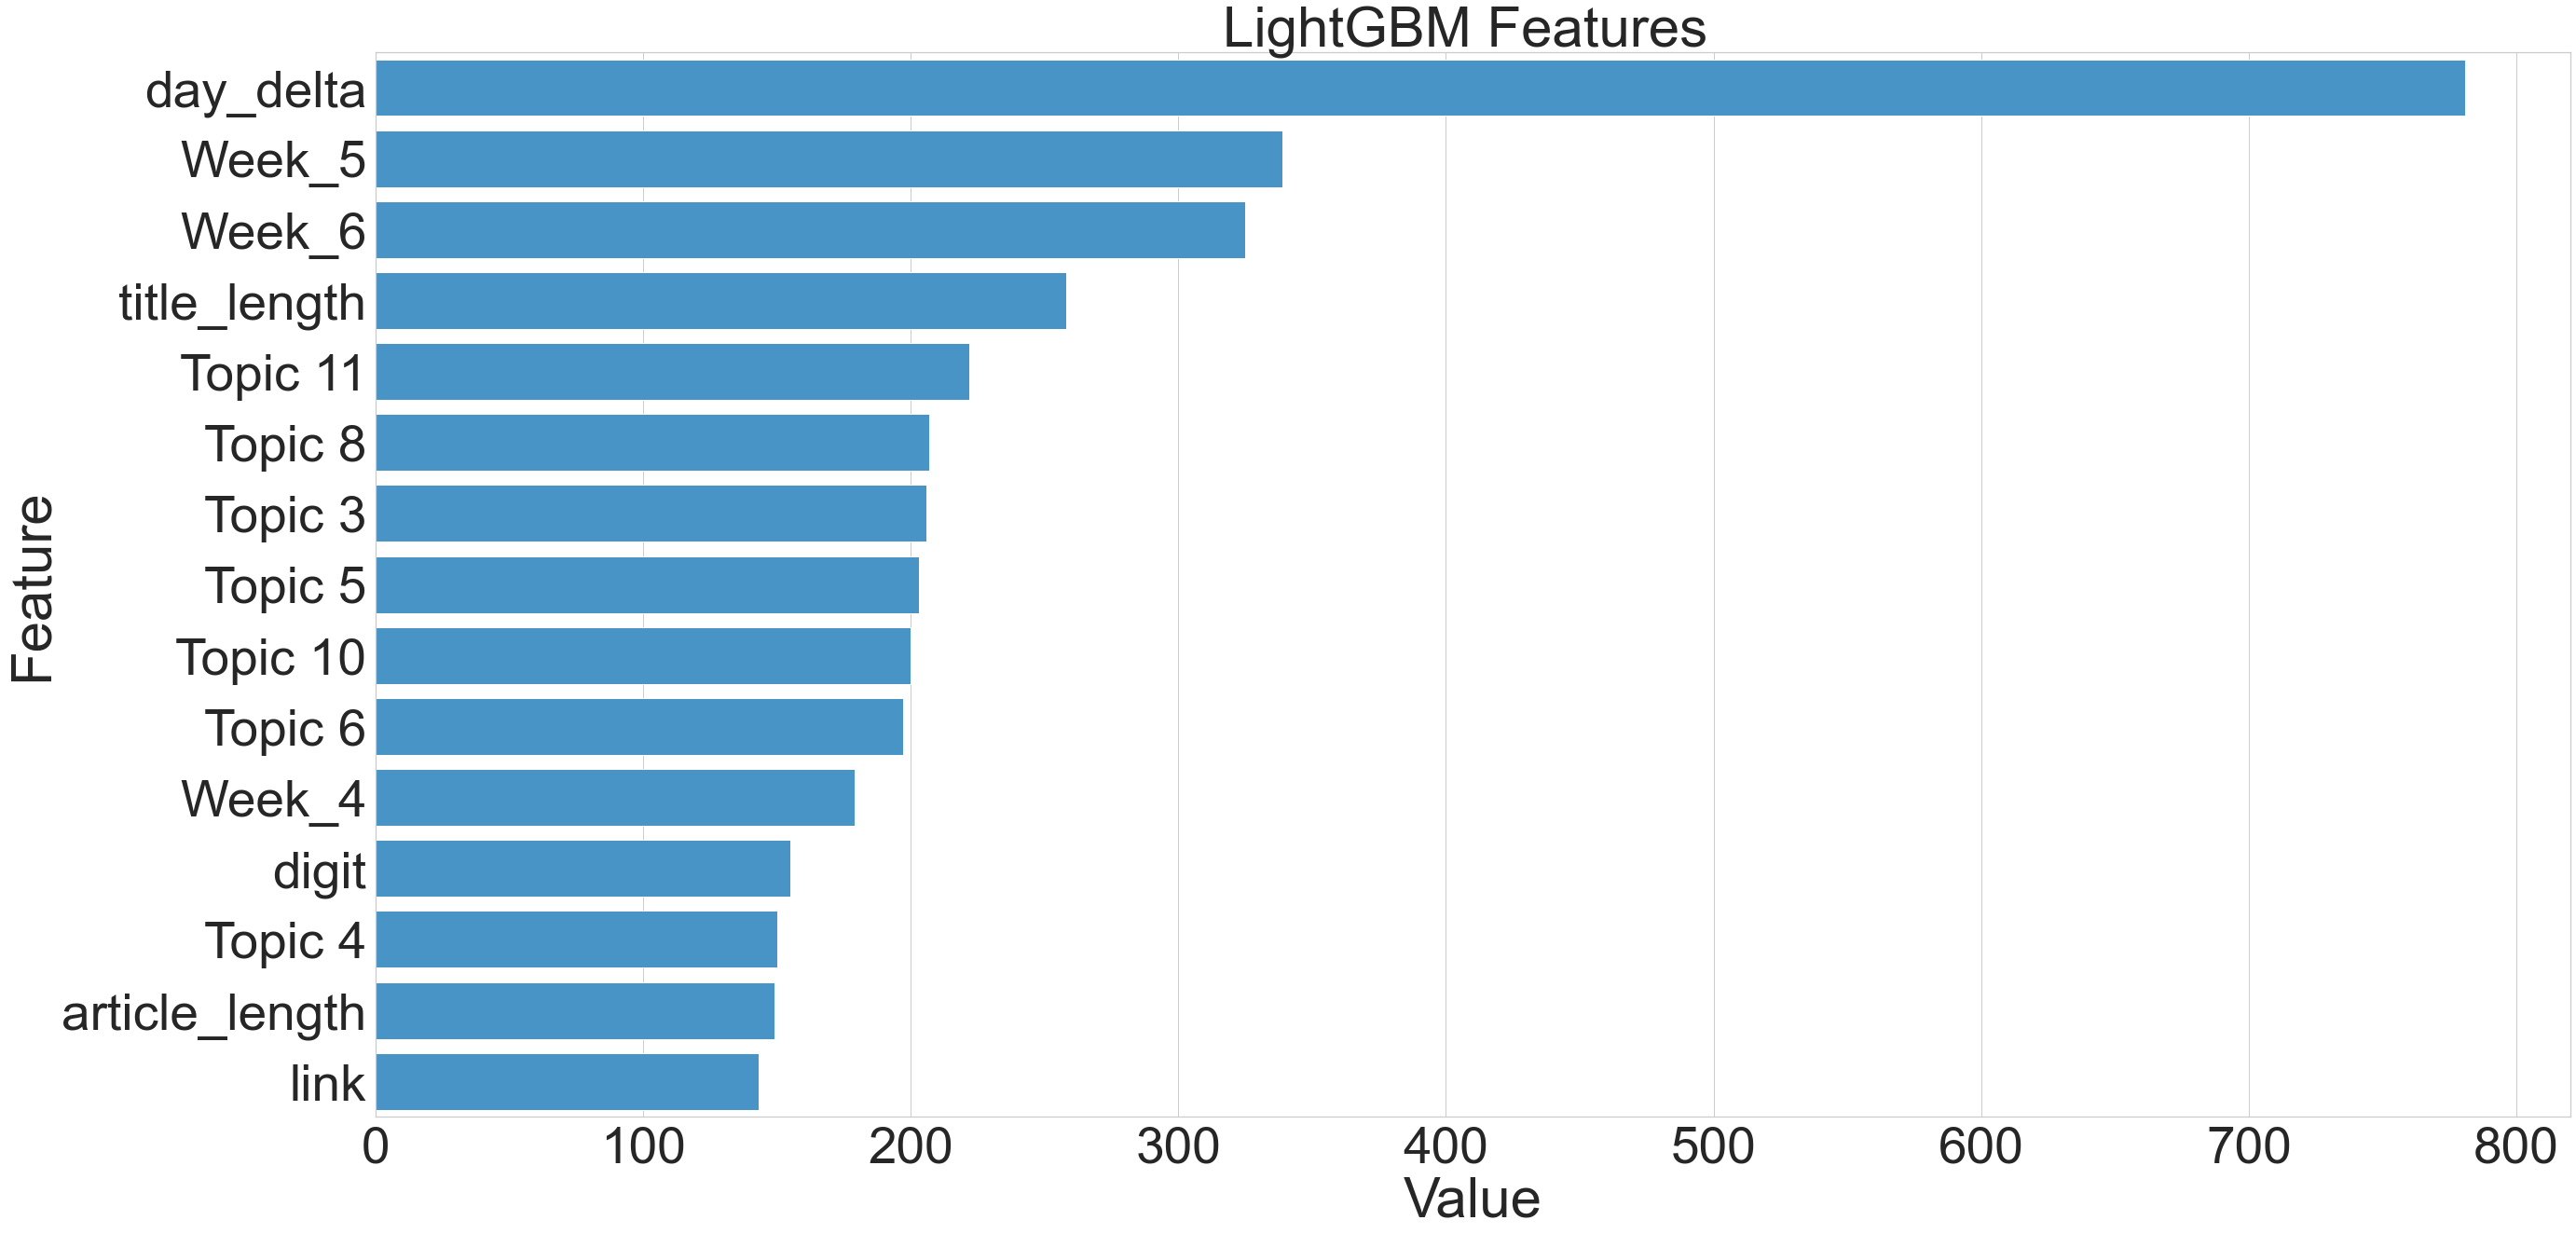

In [468]:
feature_imp = pd.DataFrame({'Value':light.feature_importances_,'Feature':X_train.columns})

plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)

sns.set_style("whitegrid")
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15], color="#3498DB")

plt.title('LightGBM Features ')
plt.tight_layout()
#plt.savefig('lgbm_importances-01.png')
plt.show()

In [449]:
y__test_pred = light.predict(df_test)

***

# **Output**

輸出預測資料

In [450]:
id = pd.read_csv('test.csv')
display(id.head())

,Id,Page content
0,27643,"<html><head><div class=""article-info""><span cl..."
1,27644,"<html><head><div class=""article-info""><span cl..."
2,27645,"<html><head><div class=""article-info""><span cl..."
3,27646,"<html><head><div class=""article-info""><span cl..."
4,27647,"<html><head><div class=""article-info""><span cl..."


In [451]:
output = {
    'Id': id['Id'],
    'Popularity': y__test_pred
}
y__test_pred = pd.DataFrame(data=output)
y__test_pred.to_csv('submission_0.5735.csv', index=False)

In [452]:
y__test_pred

,Id,Popularity
0,27643,0.455878
1,27644,0.448048
2,27645,0.457449
3,27646,0.526193
4,27647,0.485189
...,...,...
11842,39485,0.637078
11843,39486,0.503308
11844,39487,0.607323
11845,39488,0.455828


***

# **Conclusion**

- **<font size="4">特徵工程（Feature Engineering）</font>**
    - <font size="3">可以從此次競賽中，了解到了 Feature Engineering 的重要，在一開始我們只有對於文檔進行潛在主題的分佈當作變數，但不管試了許多分類器模型（如：XGBoost），AUC 的模型標準分數一直無法提高，最後加了其他的變數考慮，才讓分類結果更好</font>
    - <font size="3">一個好且有用的 feature 會比千萬個無用的 feature 來得重要；在做此次競賽時，應該花更多時間在特徵萃取上，也認知到~Feature Engineering 的重要性</font>
    - <font size="3">最後選取出幾個較重要的變數進行建模，在建模的過程中可以發現，'發文日期' 和 '文章長短'等，對於分類結果會有不錯的提升</font>
<br /><br />
- **<font size="4">模型參數選取與交叉驗證（Parameter Selection and Cross Validation）</font>**
    - <font size="3">在 Public Leaderboard 中的 AUC 分數只是一個參考，雖然可以當作評量模型好壞的依據，但若 Private Leaderboard 使用的資料分配與 Public Leaderboard 的差距太大，則最終結果將有很大的差異</font>
    - <font size="3">因此，我們在做資料前處理和建模時必須小心合理，並透過最終得出的 CV score 來當作最可靠的模型參考依據</font>
    - <font size="3">最後選取 LightGBM 做為最終的分類器，挑選參數為 'learning_rate' 為 0.005, 'max_depth' 為 7, 'n_estimators' 為 200, 'num_leaves' 為 30，在 Public Leaderboard 的 AUC 顯示 0.5661，而在 Private Leaderboard 顯示 0.5695</font>
<br /><br />
***